# Demographics

### This analysis compares the demographic characteristics of the intervention and waitlist control groups. Specifically, we compare the means of various demographic variables between the two groups using t-tests, as well as examining the distribution of categorical variables using chi-squared tests. The demographic variables include age, ethnicity, employment status, education level, and previous app use.

### This analysis provides insight into any potential differences between the two groups that may need to be accounted for in subsequent analyses. 

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
dir = '/Users/garvert/Documents/Alena/RCT/rct-data/rct-2022-11/'

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
dpi = 300

print('Age:')
t, p = stats.ttest_ind(df['age'][df['group'] == 'Waitlist'], df['age'][df['group'] == 'Intervention'])
print('Intervention mean, std: ', df['age'][df['group'] == 'Intervention'].mean(), df['age'][df['group'] == 'Intervention'].std())
print('Waitlist mean, std: ', df['age'][df['group'] == 'Waitlist'].mean(), df['age'][df['group'] == 'Waitlist'].std())
print('t: ',t, ' p: ',p, '\n')

print('Ethnicity:')
observations = pd.crosstab(index=df["eth_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)


print('\n\nEmployment:')
observations = pd.crosstab(index=df["employ_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)


print('\nEducation:')
observations = pd.crosstab(index=df["edu_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)


print('\nPrevious app use:')
observations = pd.crosstab(index=df["apps_original"], columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print(observations)
print("chi2 = ", chi2)
print("p = ", p)

# plt.rcParams.update({'font.family':'sans-serif'})
# plt.rcParams.update({'font.sans-serif':'Arial'})
# plt.rcParams.update({'font.size': 8})
plt.style.use('default')
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 8})

Age:
Intervention mean, std:  29.076923076923077 4.100914072406411
Waitlist mean, std:  27.46 4.607934594207019
t:  -1.8737644492930094  p:  0.0638826018839124 

Ethnicity:
group                         Intervention  Waitlist
eth_original                                        
Asian/Asian British                      1         3
Black/Black British                      2         2
Mixed/Multiple ethnic groups             6         2
White/White British                     43        43
chi2 =  2.9619230769230773
p =  0.39753322332500296


Employment:
group                                               Intervention  Waitlist
employ_original                                                           
Student                                                        5         7
Temporarily away from work due to illness, mate...             2         0
Unable to work due to disability or any other r...             1         1
Unemployed                                                     2    

# Adverse events

### The code extracts information on adverse events reported by the intervention and the waitlist control group and exports it to CSV files for further analysis. The code loops through CSV files in a directory for each group and week, and counts the number of participants who reported any new, serious negative health effects in the past week. 

### The data is then exported to a CSV file. The code then calculates the total number of entries and unique participants in each group, prints the results, and performs a chi-squared test to compare the total number of users and incidents between the two groups.

In [17]:
import os
import csv

# specify the directory path
dir_path = 'raw_data'

# create two separate dataframes for the intervention and waitlist groups
df = pd.DataFrame(columns=['group','pid', 'week','description'])

# loop through all files in the directory
for group in ['waitlist','intervention']:
    for week in [1,2,3,4,6]:
    
        filename = group + '_week' + str(week) + '.csv' 

        # open the csv file
        with open(os.path.join(dir_path, filename), 'r') as csv_file:
            # create a csv reader object
            csv_reader = csv.DictReader(csv_file)
            
            # count the number of "Yes" or "I'm not sure" in the column "Have you experienced any new, serious negative health effects in the past week?"
            count = 0
            for row in csv_reader:
                if row['Have you experienced any *new,* *serious* negative health effects in the past week?'] in ['Yes', "I'm not sure"]:
                    count += 1
                    pid = row['pid']
                    descr = row['We are sorry to hear this. Please briefly describe the serious negative effect(s) you have experienced.']
                    df = df.append({'group': group, 'pid': pid, 'week': week,'description': descr}, ignore_index=True)
                    
        
df.to_csv('adverse_outcomes.csv')


# count the total number of entries for each group
group_counts = df['group'].value_counts()

# count the number of unique pids in each group
unique_pids = df.groupby('group')['pid'].nunique()

# print the results
print('Total number of entries for each group:')
print(group_counts)

print('CAREFUL! In the waitlist group one user filled in the questionnaire twice, total number of entries is 17')

print('\nNumber of unique pids in each group:')
print(unique_pids)


from scipy.stats import chi2_contingency

print('\nDifference total number of users:')
obs = [[4, 9], [52, 50]]
chi2, p, dof, expected = chi2_contingency(obs)

print("Chi-squared statistic:", chi2)
print("p-value:", p)


print('\nDifference total number of incidents:')
obs = [[5, 17], [52, 50]]
chi2, p, dof, expected = chi2_contingency(obs)

print("Chi-squared statistic:", chi2)
print("p-value:", p)


Total number of entries for each group:
waitlist        18
intervention     5
Name: group, dtype: int64
CAREFUL! In the waitlist group one user filled in the questionnaire twice, total number of entries is 17

Number of unique pids in each group:
group
intervention    4
waitlist        9
Name: pid, dtype: int64

Difference total number of users:
Chi-squared statistic: 1.163103808994263
p-value: 0.2808227666316657

Difference total number of incidents:
Chi-squared statistic: 4.73414147015182
p-value: 0.029569602759872818


# Completion rates by week

### The code calculates the percentage of missing values at each time point for each group and performs a chi-square test to determine if there is a significant difference in the missing values between groups.

In [18]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

# Select the columns of interest
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
spin = df[["spintot_0","spintot_w1","spintot_w2","spintot_w3","spintot_w4","spintot_w6","group"]]

# Define a function to compute the percentage of missing values
def nonmissing_percentage(column):
    return 100 - (column.isnull().sum() / len(column) * 100)

# Compute the percentage of missing values for each column, separately for each group
grouped_spin = spin.groupby("group").agg(nonmissing_percentage)

print(grouped_spin)

# Test for statistical significance using a chi-square test
p_values = []
for column in ["spintot_0","spintot_w1","spintot_w2","spintot_w3","spintot_w4","spintot_w6"]:
    
    df['missing_data'] = df[column].isnull()
    observations = pd.crosstab(index=df["missing_data"], columns=df["group"],margins=False)
    chi2, p, dof, ex = chi2_contingency(observations)
    print('\n\n\n########################\n\nWeek '+ column[-1])
    print(observations)
    print("chi2 = ", chi2)
    print("p = ", p)


              spintot_0  spintot_w1  spintot_w2  spintot_w3  spintot_w4  \
group                                                                     
Intervention      100.0   96.153846   94.230769   96.153846   94.230769   
Waitlist          100.0  100.000000   98.000000  100.000000   92.000000   

              spintot_w6  
group                     
Intervention   88.461538  
Waitlist       88.000000  



########################

Week 0
group         Intervention  Waitlist
missing_data                        
False                   52        50
chi2 =  0.0
p =  1.0



########################

Week 1
group         Intervention  Waitlist
missing_data                        
False                   50        50
True                     2         0
chi2 =  0.4709653846153845
p =  0.49254338144510046



########################

Week 2
group         Intervention  Waitlist
missing_data                        
False                   49        49
True                     3         1
chi

# Acceptability

### This analysis examines the acceptability of the intervention. The first section of the code compares the reported completion rates of the intervention group at different time points. The second section of the code plots a histogram showing the number of completed modules by participants at the end of the four-week intervention.

### The remaining sections of the code examine the satisfaction, helpfulness, ease of use, recommendation, and completion rates of the intervention program. For each of these variables, the code creates a plot that displays the percentage of responders who fall into different response categories at different time points. The plots are saved to an output file called 'acceptability.eps'.

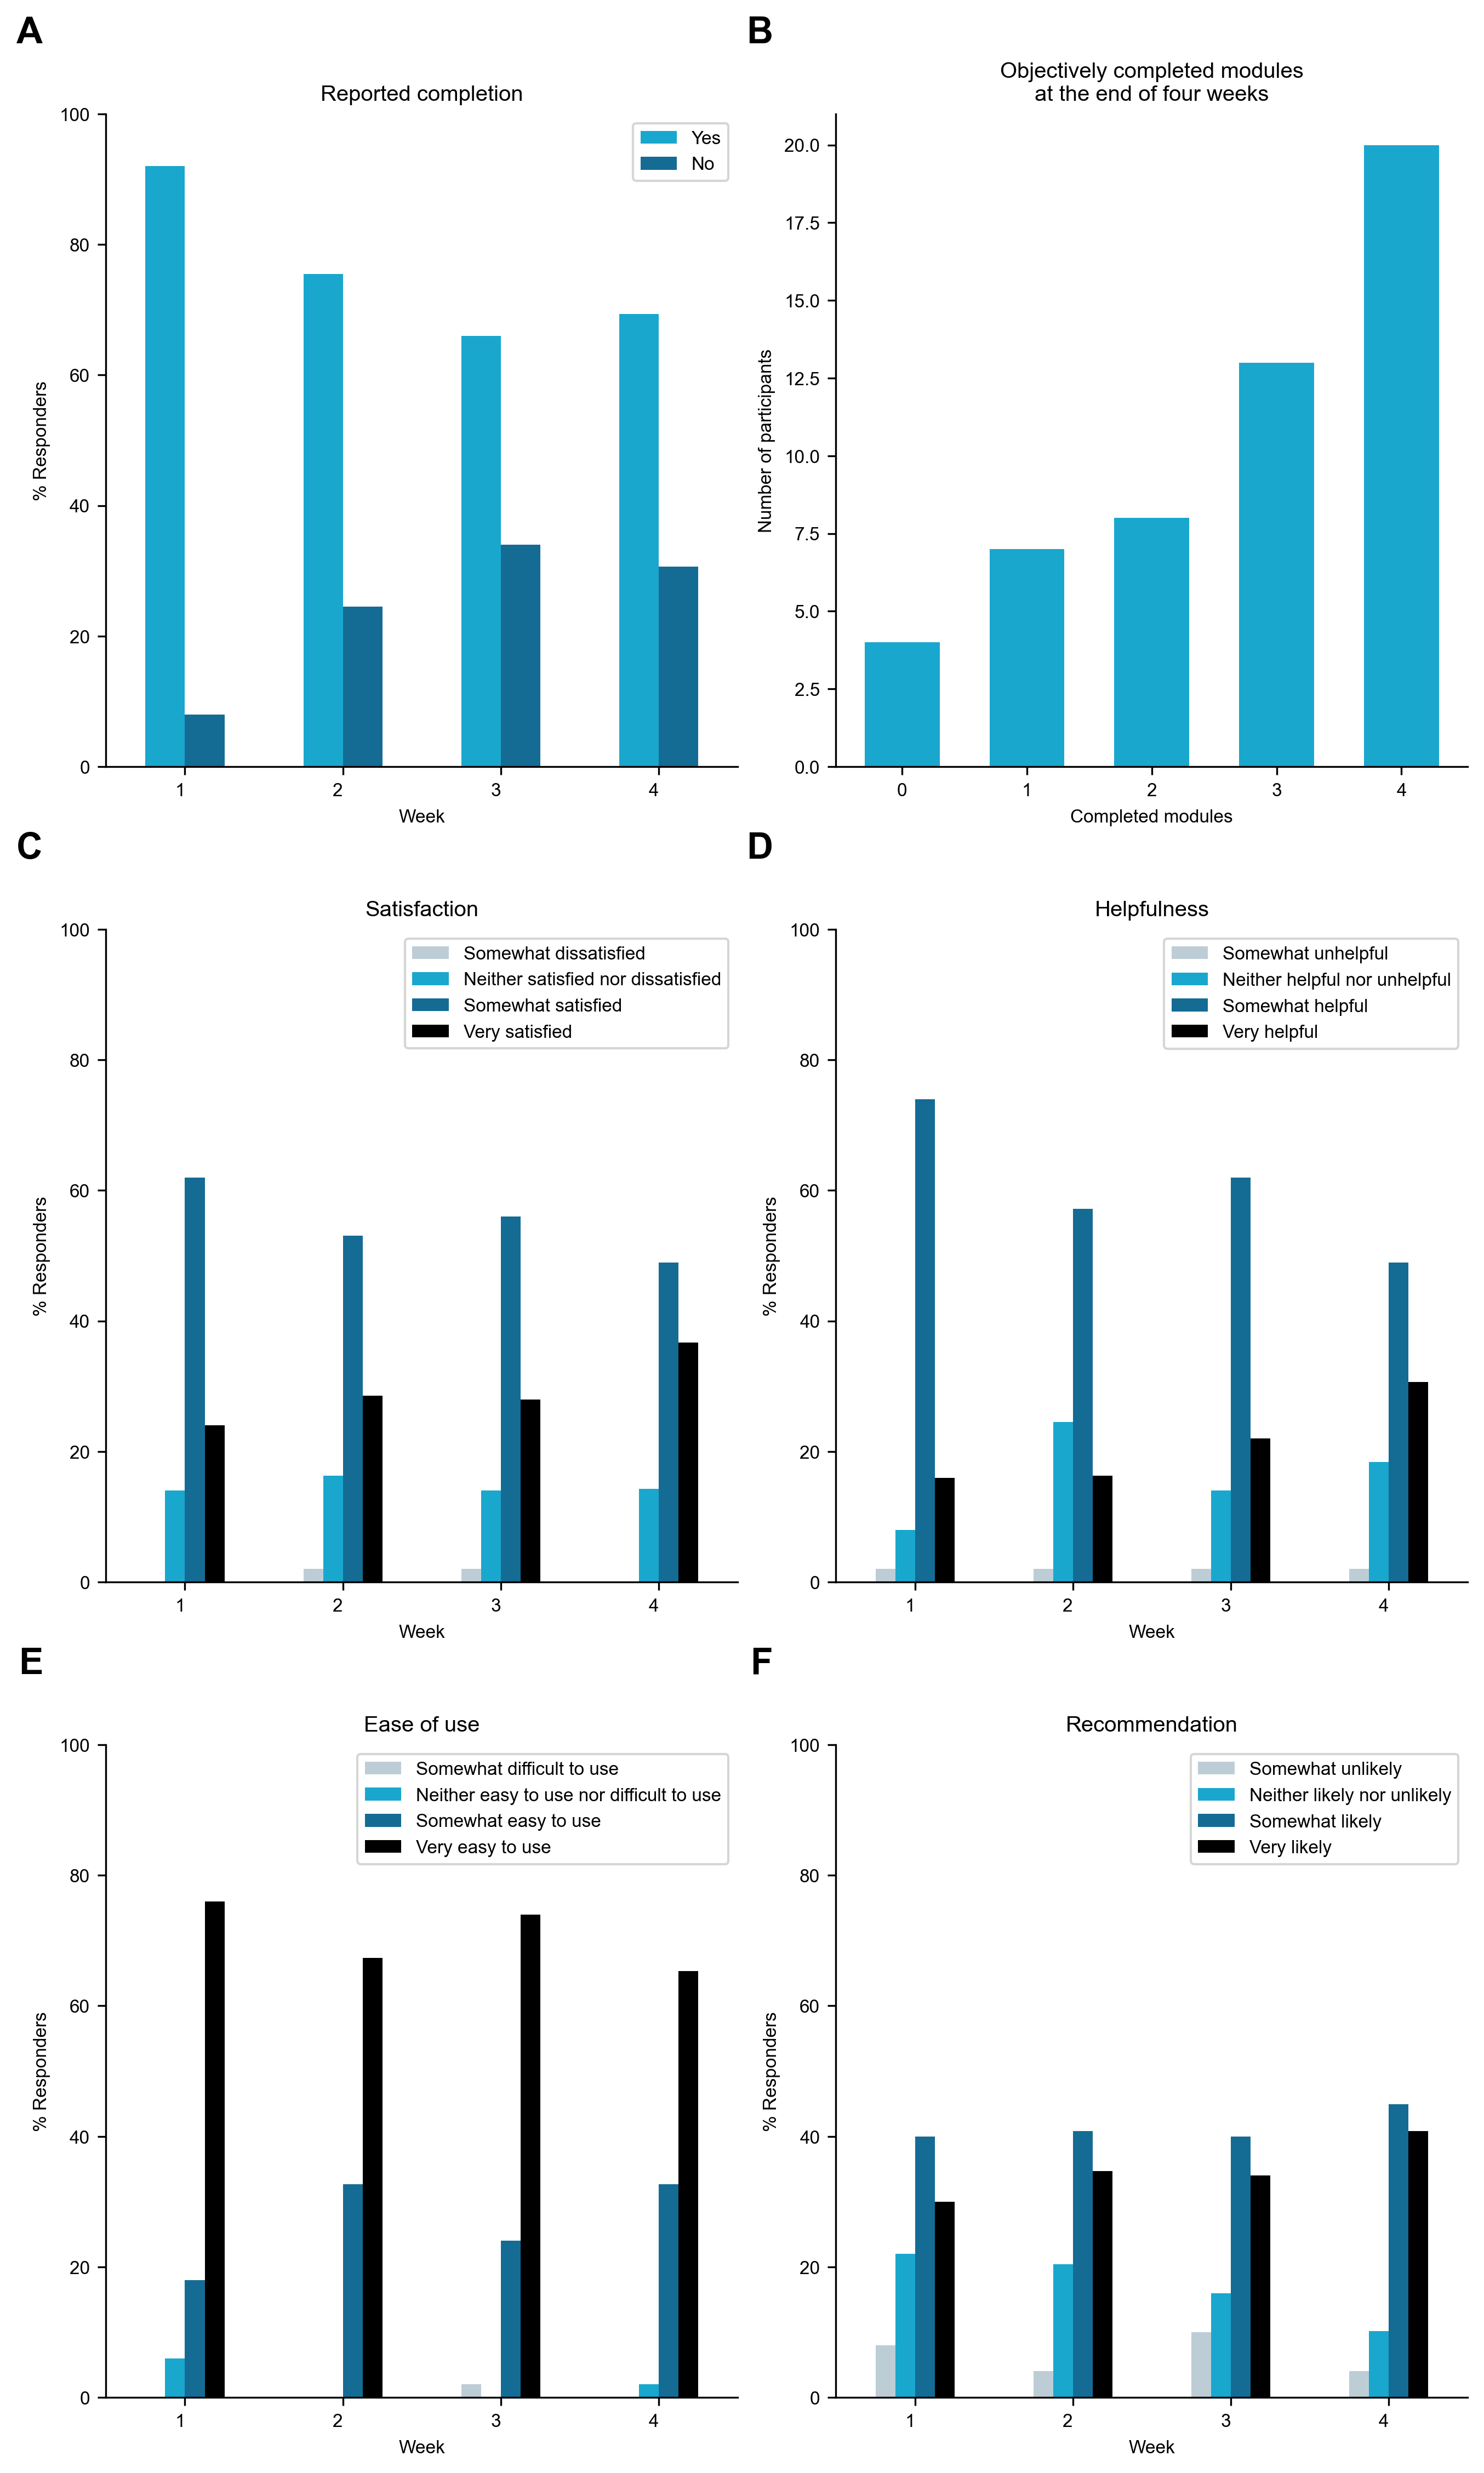

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [19]:
# Acceptability data
import statsmodels.api as sm
import statsmodels.formula.api as smf

dpi = 300
df_int = df[df['group'] == 'Intervention']

title = 'Reported completion'
variables = ['end_original_w']
order = {'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,15), dpi = dpi)

vix = 'end_original_w'
satis = df_int[[vix+"1",vix+"2",vix+"3",vix+"4"]]
satis = pd.melt(satis, value_vars = [vix+"1",vix+"2",vix+"3",vix+"4"])
freq = pd.crosstab(satis.variable, satis.value, normalize='index')*100
freq = freq[order[vix]]

ax = fig.add_subplot(3,2,1)
ax.text(-0.1, 1.15, 'A', transform=ax.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')

g = freq.plot(kind='bar', color=["#19A7CE","#146C94", "#000000"], ax = ax)
g.set(xticklabels = ['1','2','3','4'], ylim = (0,100), xlabel = 'Week', ylabel = '% Responders', title = title)
plt.xticks(rotation=360, ha='right')
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0, title='')

satis = df_int[['M0M1complete','M2complete',	'M3complete',	'M4complete']]
df = satis.mean(axis = 1)*4

ax = fig.add_subplot(3,2,2)
df.plot.hist(bins = [-0.3,0.3,0.7,1.3,1.7,2.3,2.7,3.3,3.7,4.3], color = ["#19A7CE"])
ax.set_xlabel('Completed modules')
ax.set_ylabel('Number of participants')
ax.set_title('Objectively completed modules\nat the end of four weeks')
ax.spines[['right', 'top']].set_visible(False)
ax.text(-0.1, 1.15, 'B', transform=ax.transAxes,
  fontsize=16, fontweight='bold', va='top', ha='right')



title = ['Satisfaction', 'Helpfulness', 'Ease of use', 'Recommendation', 'Completion']
variables = ['satis_original_w', 'help_original_w','easy_original_w','recc_original_w', 'end_original_w']

order = {'satis_original_w': ['Somewhat dissatisfied','Neither satisfied nor dissatisfied','Somewhat satisfied','Very satisfied'],
'help_original_w': ['Somewhat unhelpful','Neither helpful nor unhelpful','Somewhat helpful','Very helpful'],
'recc_original_w': ['Somewhat unlikely','Neither likely nor unlikely','Somewhat likely','Very likely'],
'easy_original_w': ['Somewhat difficult to use','Neither easy to use nor difficult to use','Somewhat easy to use','Very easy to use'],
'end_original_w': ['Yes','No']}

import matplotlib.pyplot as plt

for i, label in enumerate(('C', 'D', 'E', 'F')):
    vix = variables[i]
    satis = df_int[[vix+"1",vix+"2",vix+"3",vix+"4"]]
    satis = pd.melt(satis, value_vars = [vix+"1",vix+"2",vix+"3",vix+"4"])
    freq = pd.crosstab(satis.variable, satis.value, normalize='index')*100
    freq = freq[order[vix]]

    ax = fig.add_subplot(3,2,i+3)
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

    g = freq.plot(kind='bar', color=["#BDCDD6", "#19A7CE","#146C94", "#000000"], ax = ax)
    g.set(xticklabels = ['1','2','3','4'], ylim = (0,100), xlabel = 'Week', ylabel = '% Responders', title = title[i])
    plt.xticks(rotation=360, ha='right')
    ax.spines[['right', 'top']].set_visible(False)
    ax.legend(loc=0, title='')

plt.tight_layout()
    
plt.show()
fig.savefig('figures/acceptability.eps', transparent=False)


# Efficacy

### This code visualizes the results of the RCT in terms of efficacy. The trial has two groups: a waitlist control group and an intervention group. The trial measures two outcomes, a SPIN score and a WSAS score, measured at baseline (week 0), and then at weeks 1, 2, 3, 4 and 6.

### The code first performs an intention-to-treat analysis on SPIN and WSAS scores, which includes all randomized participants regardless of adherence to the intervention. The lines represent mean and standard errors. The intention-to-treat analysis is followed by a per-protocol analysis, which includes only participants who completed the intervention. The figure is then saved as an eps file.

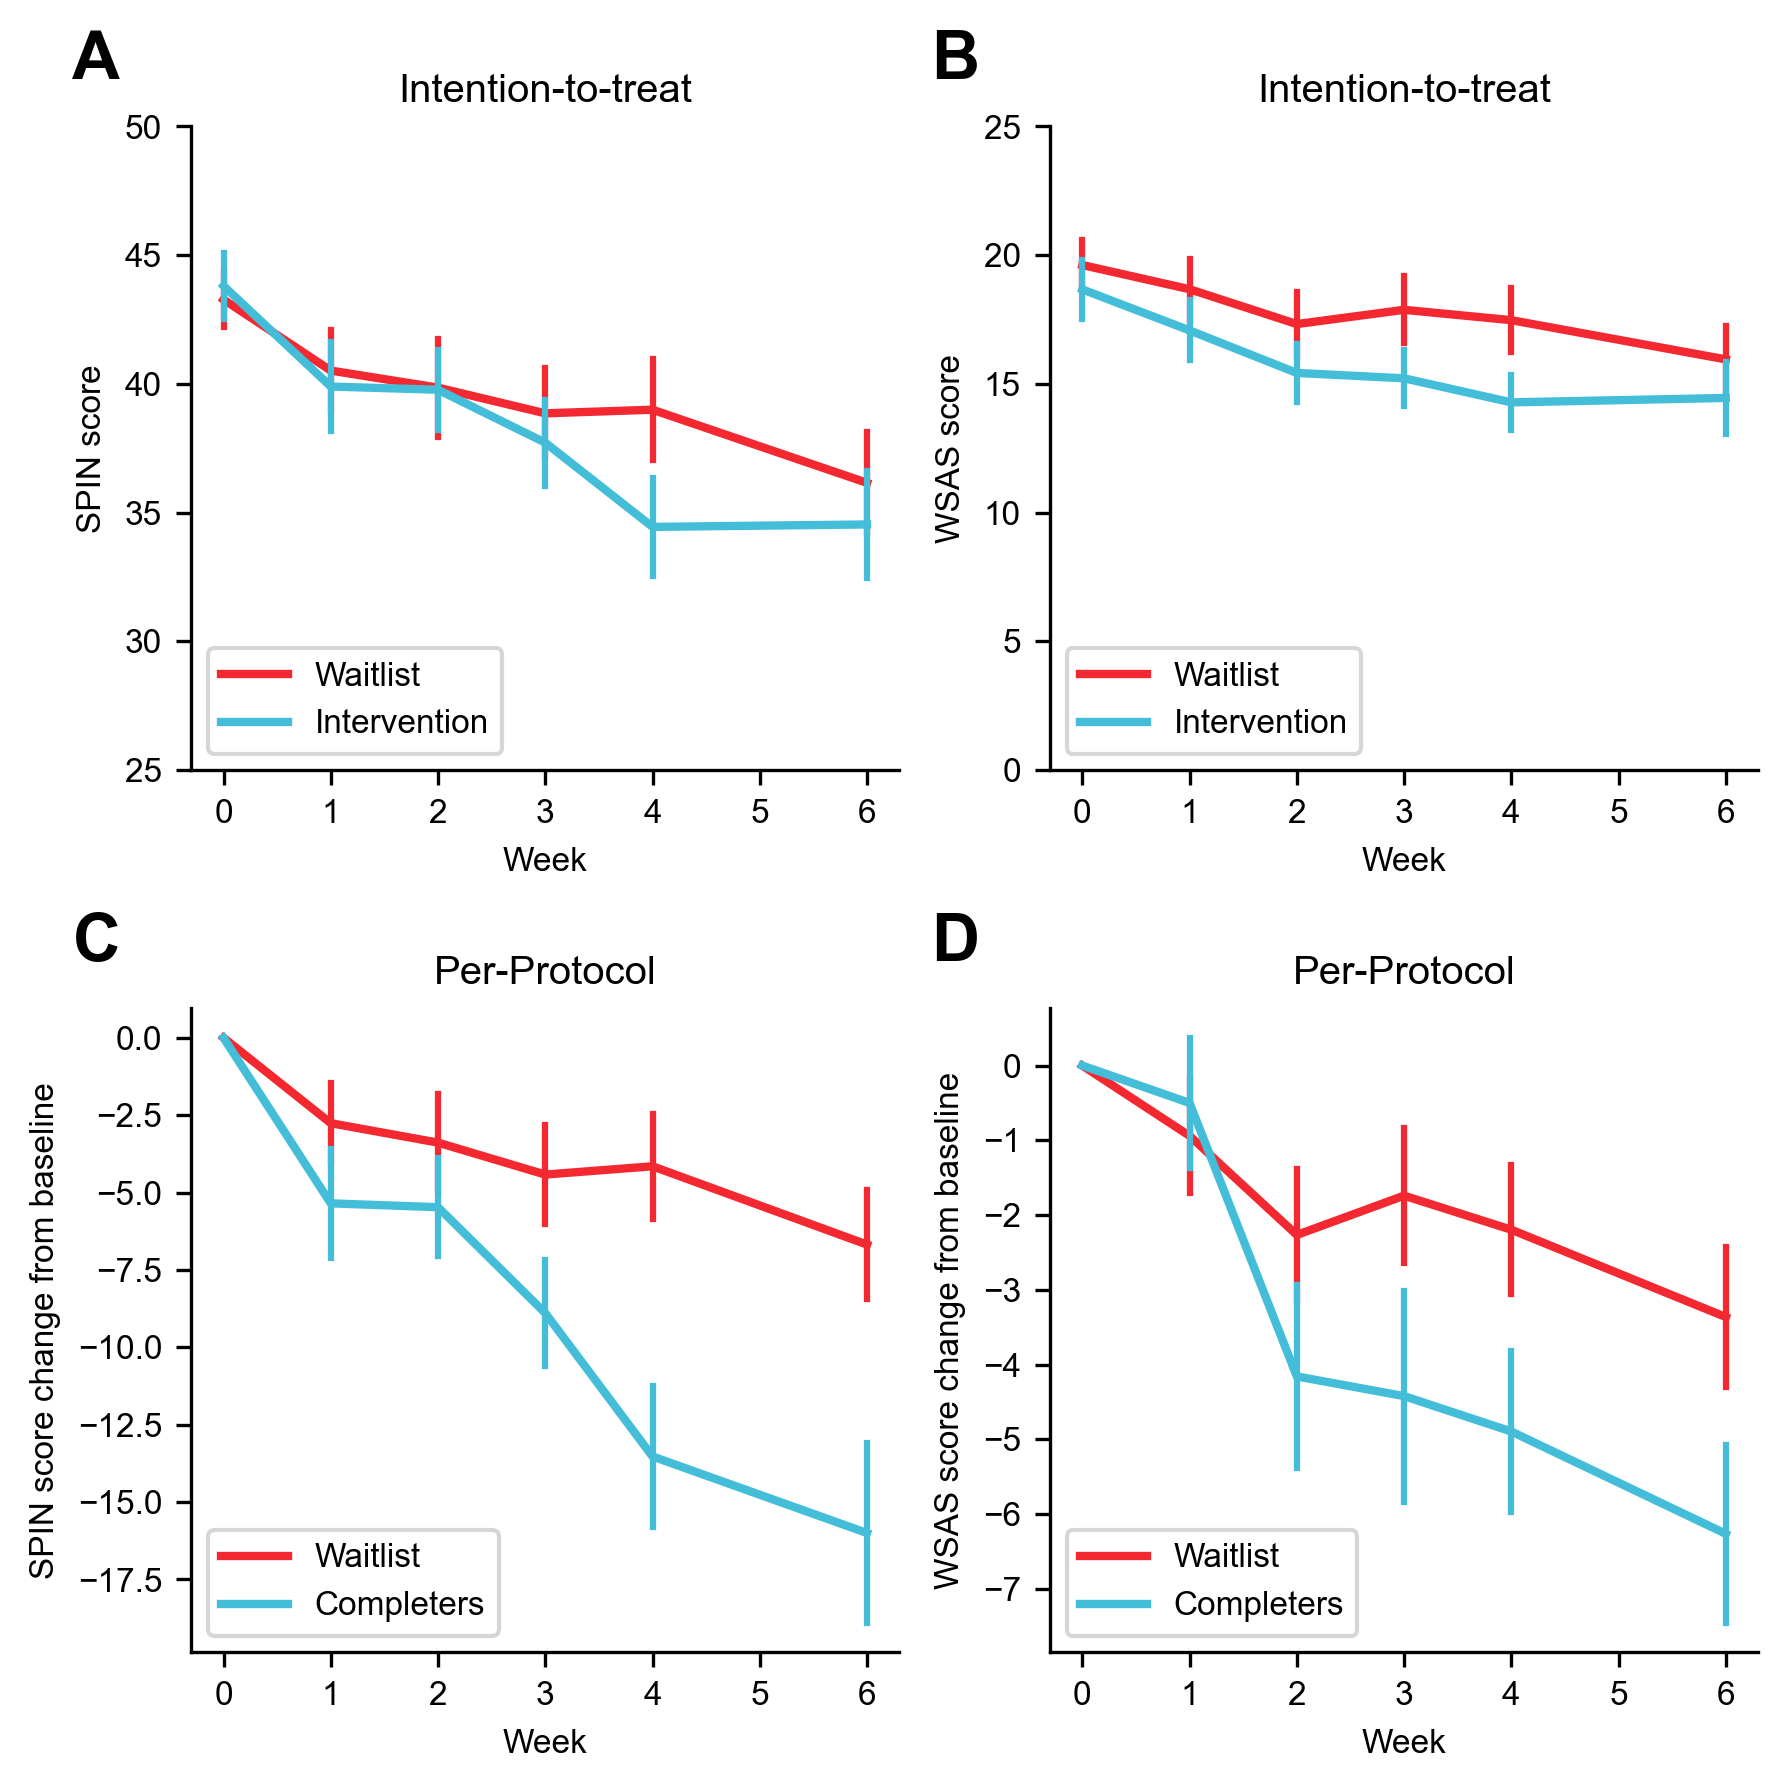

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:

#Intention-to-treat analysis
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df["spintot_w5"] = np.nan

spin = df[["spintot_0","spintot_w1","spintot_w2","spintot_w3","spintot_w4","spintot_w5","spintot_w6","group"]]
spin_melted = spin.melt(id_vars = 'group', var_name="timepoint", value_name="SPIN score")

wsas = df[["wsastot_0","wsastot_w1","wsastot_w2","wsastot_w3","wsastot_w4","spintot_w5","wsastot_w6","group"]]
wsas_melted = wsas.melt(id_vars = 'group', var_name="timepoint", value_name="WSAS score")

fig = plt.figure(figsize=(6,6), dpi = dpi)
for i, label in enumerate(('A', 'B')):
    ax = fig.add_subplot(2,2,i+1)
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
    if i == 0:
        g = sns.lineplot(data=spin_melted, x = 'timepoint', y = 'SPIN score', hue = 'group', 
                        err_style="bars", errorbar=("se"), palette=["#f42831", "#44bed8"], linewidth=2, ax = ax)
        ax.legend(labels=["Waitlist","Intervention"], loc = 3)
        g.set(xticklabels = ['0','1','2','3','4','5',"6"], ylim = (25,50), xlabel = 'Week', title='Intention-to-treat')
        ax.spines[['right', 'top']].set_visible(False)

    else:
        g = sns.lineplot(data=wsas_melted, x = 'timepoint', y = 'WSAS score', hue = 'group', 
                        err_style="bars", errorbar=("se"), palette=["#f42831", "#44bed8"], linewidth=2, ax = ax)
        g.set(xticklabels = ['0','1','2','3','4','5',"6"], ylim = (0,25), xlabel = 'Week', title='Intention-to-treat')
        ax.spines[['right', 'top']].set_visible(False)
        ax.legend(labels=["Waitlist","Intervention"], loc = 3)


# Per-protocol analysis
df = df.drop(df[df.completed== 0].index)
df.head()


spin = df[["spintot_0","spintot_w1","spintot_w2","spintot_w3","spintot_w4","spintot_w5","spintot_w6","group"]]
spin.iloc[:, 0:-1] = spin.iloc[:, 0:-1].sub(spin["spintot_0"], axis=0)
spin_melted = spin.melt(id_vars = 'group', var_name="timepoint", value_name="SPIN score")


wsas = df[["wsastot_0","wsastot_w1","wsastot_w2","wsastot_w3","wsastot_w4","spintot_w5","wsastot_w6","group"]]
wsas.iloc[:, 0:-1] = wsas.iloc[:, 0:-1].sub(wsas["wsastot_0"], axis=0)
wsas_melted = wsas.melt(id_vars = 'group', var_name="timepoint", value_name="WSAS score")


for i, label in enumerate(('C', 'D')):
    ax = fig.add_subplot(2,2,i+3)
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    
    if i == 0:
        g = sns.lineplot(data=spin_melted, x = 'timepoint', y = 'SPIN score', hue = 'group', 
                        err_style="bars", errorbar=("se"), palette=["#f42831", "#44bed8"], linewidth=2, ax = ax)
        ax.legend(labels=["Waitlist","Completers"], loc = 3)
        g.set(xticklabels = ['0','1','2','3','4','5',"6"], xlabel = 'Week', ylabel = 'SPIN score change from baseline', title='Per-Protocol')
        ax.spines[['right', 'top']].set_visible(False)

    else:
        g = sns.lineplot(data=wsas_melted, x = 'timepoint', y = 'WSAS score', hue = 'group', 
                        err_style="bars", errorbar=("se"), palette=["#f42831", "#44bed8"], linewidth=2, ax = ax)
        g.set(xticklabels = ['0','1','2','3','4','5',"6"], xlabel = 'Week', ylabel = 'WSAS score change from baseline', title='Per-Protocol')
        ax.spines[['right', 'top']].set_visible(False)
        ax.legend(labels=["Waitlist","Completers"], loc = 3)

plt.tight_layout()
plt.show()
fig.savefig('figures/efficacy.eps', transparent=False)


# Change in SPIN in an intention-to-treat sample by week

### Regression analyses are performed on the data separately for each time point, represented by variables 'spintot_w1', 'spintot_w2', 'spintot_w3', 'spintot_w4', and 'spintot_w6'. Each iteration of the loop predicts SPIN at the current time point, and includes 'group', 'spintot_0' and 'age' as regressors. The analysis is done under an intention-to-treat framework, which means that all participants are analyzed according to the group to which they were randomized, regardless of whether or not they received the intervention.


In [21]:
# Regression analyses, intention-to-treat, SPIN
import statsmodels.api as sm

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)


for time in ['spintot_w1', 'spintot_w2', 'spintot_w3', 'spintot_w4','spintot_w6']:
    d = df[['group','spintot_0','age',time]]

    just_dummies = pd.get_dummies(d['group'])
    step1 = pd.concat([d,just_dummies], axis = 1)

    result = sm.OLS(step1[time], sm.add_constant(step1[['spintot_0', 'Intervention','age']]), missing='drop').fit()
    print('\n\n\n########################\n\nWeek '+ time[-1])
    print (result.summary())





########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             spintot_w1   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     21.84
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           7.25e-11
Time:                        11:22:44   Log-Likelihood:                -360.24
No. Observations:                 100   AIC:                             728.5
Df Residuals:                      96   BIC:                             738.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Change in WSAS in an intention-to-treat sample by week

### Regression analyses are performed on the data separately for each time point, represented by variables 'wsastot_w1', 'wsastot_w2', 'wsastot_w3', 'wsastot_w4', and 'wsastot_w6'. Each iteration of the loop predicts WSAS at the current time point, and includes 'group', 'wsastot_0' and 'age' as regressors. The analysis is done under an intention-to-treat framework, which means that all participants are analyzed according to the group to which they were randomized, regardless of whether or not they received the intervention.


In [22]:
# Regression analyses, intention-to-treat WSAS
import statsmodels.api as sm

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)


for time in ['wsastot_w1', 'wsastot_w2', 'wsastot_w3', 'wsastot_w4','wsastot_w6']:
    d = df[['group','wsastot_0','age',time]]

    just_dummies = pd.get_dummies(d['group'])
    step1 = pd.concat([d,just_dummies], axis = 1)

    result = sm.OLS(step1[time], sm.add_constant(step1[['wsastot_0', 'Intervention','age']]), missing='drop').fit()
    print('\n\n\n########################\n\nWeek '+ time[-1])
    print (result.summary())





########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             wsastot_w1   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     56.64
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           3.66e-21
Time:                        11:22:44   Log-Likelihood:                -301.90
No. Observations:                 100   AIC:                             611.8
Df Residuals:                      96   BIC:                             622.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Change in SPIN in a per-protocol sample by week

### The code performs regression analyses for per-protocol analysis on the SPIN data, i.e only participants in the intervention group are included who completed all therapy modules. Regression analyses are performed on the data separately for each time point, represented by variables 'spintot_w1', 'spintot_w2', 'spintot_w3', 'spintot_w4', and 'spintot_w6'. Each iteration of the loop predicts SPIN at the current time point, and includes 'group', 'spintot_0' and 'age' as regressors. 

In [23]:
# Regression analyses, per-protocol, SPIN
import statsmodels.api as sm
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df = df.drop(df[df.completed== 0].index)


for time in ['spintot_w1', 'spintot_w2', 'spintot_w3', 'spintot_w4','spintot_w6']:
    d = df[['group','spintot_0','age',time]]

    just_dummies = pd.get_dummies(d['group'])
    step1 = pd.concat([d,just_dummies], axis = 1)

    result = sm.OLS(step1[time], sm.add_constant(step1[['spintot_0', 'Intervention','age']]), missing='drop').fit()
    print('\n\n\n########################\n\nWeek '+ time[-1])
    print (result.summary())





########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             spintot_w1   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     16.33
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           4.83e-08
Time:                        11:22:44   Log-Likelihood:                -249.54
No. Observations:                  70   AIC:                             507.1
Df Residuals:                      66   BIC:                             516.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Change in WSAS in a per-protocol sample by week

### The code performs regression analyses for per-protocol analysis on the WSAS data, i.e only participants in the intervention group are included who completed all therapy modules. Regression analyses are performed on the data separately for each time point, represented by variables 'wsastot_w1', 'wsastot_w2', 'wsastot_w3', 'wsastot_w4', and 'wsastot_w6'. . Each iteration of the loop predicts SPIN at the current time point, and includes 'group', 'wsastot_0' and 'age' as regressors. 

In [24]:
# Regression analyses, per-protocol WSAS
import statsmodels.api as sm

df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df = df.drop(df[df.completed== 0].index)


for time in ['wsastot_w1', 'wsastot_w2', 'wsastot_w3', 'wsastot_w4','wsastot_w6']:
    d = df[['group','wsastot_0','age',time]]

    just_dummies = pd.get_dummies(d['group'])
    step1 = pd.concat([d,just_dummies], axis = 1)

    result = sm.OLS(step1[time], sm.add_constant(step1[['wsastot_0', 'Intervention','age']]), missing='drop').fit()
    print('\n\n\n########################\n\nWeek '+ time[-1])
    print (result.summary())





########################

Week 1
                            OLS Regression Results                            
Dep. Variable:             wsastot_w1   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     48.15
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           1.31e-16
Time:                        11:22:44   Log-Likelihood:                -209.75
No. Observations:                  70   AIC:                             427.5
Df Residuals:                      66   BIC:                             436.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const       

# Reliable change in SPIN in intention-to-treat sample at week 4

### This code computes the change in SPIN for each participant as the difference between their baseline score (spintot_0) and their score at week 4 (spintot_w4). It then creates a contingency table, with one column for each treatment group (Intervention and Control) and one row indicating whether or not the improvement was greater than or equal to 10 points.

### It then computes the chi-squared test statistic and associated p-value for the contingency table. The observed contingency table, chi-squared test statistic, and p-value are printed to the console.

### Finally, the code creates a second contingency table with the same row variable but normalized across the columns.

In [25]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df['reliable_improvement'] = (df['spintot_0'] - df['spintot_w4']) 

observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

print("\n### Relative numbers\n")
rel_observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False, normalize='columns')
print(rel_observations)


### Absolute numbers 

group                 Intervention  Waitlist
reliable_improvement                        
False                           28        40
True                            24        10

chi2 =  6.7133653846153845
p =  0.009569296332157959

### Relative numbers

group                 Intervention  Waitlist
reliable_improvement                        
False                     0.538462       0.8
True                      0.461538       0.2


# Reliable change in SPIN in per-protocol sample at week 4

### This code computes the change in SPIN for each participant as the difference between their baseline score (spintot_0) and their score at week 4 (spintot_w4). It then creates a contingency table, with one column for each treatment group (Intervention and Control) and one row indicating whether or not the improvement was greater than or equal to 10 points. The intervention group only includes participants who completed all therapy modules

### It then computes the chi-squared test statistic and associated p-value for the contingency table. The observed contingency table, chi-squared test statistic, and p-value are printed to the console.

### Finally, the code creates a second contingency table with the same row variable but normalized across the columns.

In [26]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df = df.drop(df[df.completed== 0].index)
df['reliable_improvement'] = (df['spintot_0'] - df['spintot_w4']) 

observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

rel_observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False, normalize='columns')
print("\n### Relative numbers\n")
print(rel_observations)


### Absolute numbers 

group                 Intervention  Waitlist
reliable_improvement                        
False                            6        40
True                            14        10

chi2 =  13.709918478260873
p =  0.0002133248916488108

### Relative numbers

group                 Intervention  Waitlist
reliable_improvement                        
False                          0.3       0.8
True                           0.7       0.2


# Reliable change in SPIN in intention-to-treat sample at week 6

In [27]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)

df['reliable_improvement'] = (df['spintot_0'] - df['spintot_w6']) 

observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers \n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

rel_observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False, normalize='columns')
print("\n### Relative numbers\n")
print(rel_observations)


### Absolute numbers 

group                 Intervention  Waitlist
reliable_improvement                        
False                           31        35
True                            21        15

chi2 =  0.791896853146854
p =  0.3735271743967694

### Relative numbers

group                 Intervention  Waitlist
reliable_improvement                        
False                     0.596154       0.7
True                      0.403846       0.3


# Reliable change in SPIN in per-protocol sample at week 6

In [28]:
df = pd.read_csv(dir + 'preprocessed_data/merged.csv', delimiter=',', error_bad_lines=False)
df = df.drop(df[df.completed== 0].index)
df['reliable_improvement'] = (df['spintot_0'] - df['spintot_w6']) 

observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False)
chi2, p, dof, ex = chi2_contingency(observations)
print("\n### Absolute numbers\n")
print(observations)
print("\nchi2 = ", chi2)
print("p = ", p)

rel_observations = pd.crosstab(index=df["reliable_improvement"]>=10, columns=df["group"],margins=False, normalize='columns')
print("\n### Relative numbers\n")
print(rel_observations)


### Absolute numbers

group                 Intervention  Waitlist
reliable_improvement                        
False                            6        35
True                            14        15

chi2 =  7.843355761143817
p =  0.005100783069968119

### Relative numbers

group                 Intervention  Waitlist
reliable_improvement                        
False                          0.3       0.7
True                           0.7       0.3


# Exploratory analyses examining the effect of specific interventions on SPIN

### The figure shows the relationship between the the number of completed modules and SPIN at baseline (A), change in SPIN after four weeks (B) and change in SPIN after 6 weeks (C). Displayed are the mean and error bars as a function of completed modules. There are large baseline SPIN differences between the different groups here that are likely to explain the changes in SPIN after 4 and 6 weeks.

### D-F show baseline SPIN, SPIN change after 4 weeks and SPIN change after 6 weeks by individual module completed (left: not completed, right: completed). 

### Linear regression models are computed that predict SPIN scores after four weeks using completion of a particular module, total number of completed modules, age, and baseline SPIN score. A separate regression model is set up for each module. Completion of module 3 is the only one that has a significant effect on SPIN at 4 weeks when accounting for baseline SPIN, total completed modules and age. 

### A final regression analysis includes all modules in the same regression analysis to account for potential correlations between module completions.

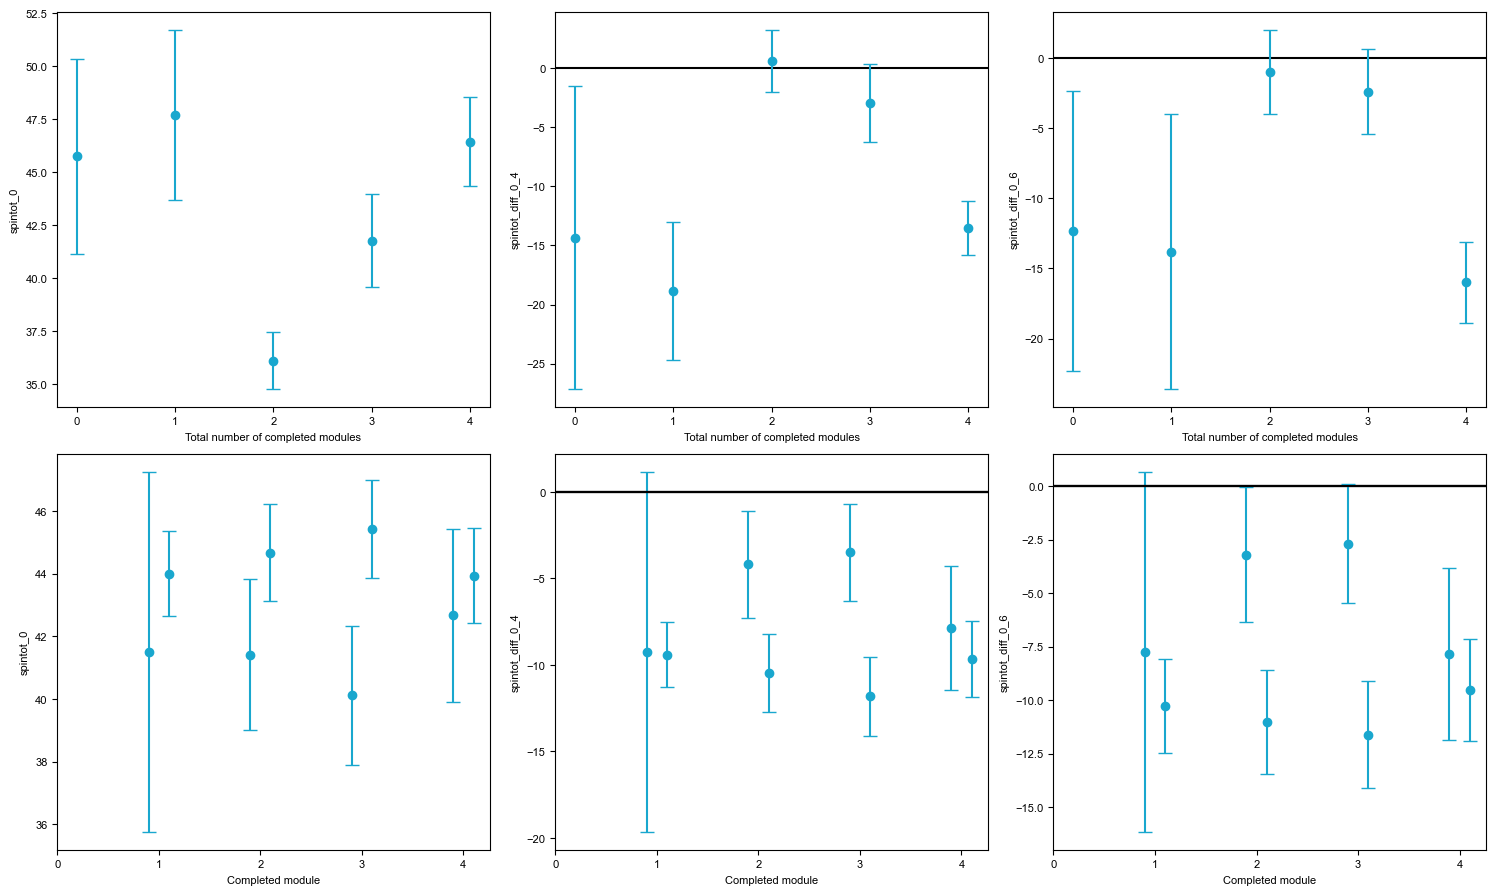




########################
Effect of completing module 1

                            OLS Regression Results                            
Dep. Variable:       spintot_diff_0_4   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.130
Date:                Fri, 14 Apr 2023   Prob (F-statistic):             0.0931
Time:                        11:22:45   Log-Likelihood:                -190.49
No. Observations:                  49   AIC:                             391.0
Df Residuals:                      44   BIC:                             400.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [29]:

vix = 'end_original_w'
satis = df_int[[vix+"1",vix+"2",vix+"3",vix+"4", 'M0M1complete','M2complete', 'M3complete',	'M4complete', "spintot_0","spintot_w1","spintot_w2","spintot_w3","spintot_w4","spintot_w6",'age']]

# change in SPIN 
satis['spintot_diff_0_4'] = satis['spintot_w4'] - satis['spintot_0']
satis['spintot_diff_0_6'] = satis['spintot_w6'] - satis['spintot_0']

# total number of completed modules
satis['M_sum'] = satis[['M0M1complete','M2complete','M3complete','M4complete']].sum(axis=1)

# 
fig = plt.figure(figsize=(15,9))
for counter, toplot in enumerate(['spintot_0', 'spintot_diff_0_4', 'spintot_diff_0_6']):

    # Calculate mean and standard error of the mean for each group of M_sum values
    grouped = satis.groupby('M_sum')
    means = grouped[toplot].mean()
    sems = grouped[toplot].sem()

    ax = fig.add_subplot(2,3,counter+1)
    if counter > 0:
        ax.axhline(y=0, color = 'k')
    ax.errorbar(means.index, means, yerr=sems, fmt='o', capsize=5, color="#19A7CE", mec="#19A7CE")
    ax.set(xticks = [0,1,2,3,4], xlabel = 'Total number of completed modules', ylabel = toplot)


for counter, toplot in enumerate(['spintot_0', 'spintot_diff_0_4','spintot_diff_0_6']):

    ax = fig.add_subplot(2,3,counter+4)
    for i in [1,2,3,4]:
            
        # Calculate mean and standard deviation for each group of M_sum values
        grouped = satis.groupby(vix+str(i))
        means = grouped[toplot].mean()
        sems = grouped[toplot].sem()

        # Plot means with error bars
        if counter > 0:
            ax.axhline(y=0, color = 'k')
        ax.errorbar([i-0.1, i+0.1], means, yerr=sems, fmt='o', capsize=5, color="#19A7CE", mec="#19A7CE")
        ax.set(xticks = [0,1,2,3,4], xlabel = 'Completed module', ylabel = toplot)

plt.tight_layout()
plt.show()


# Completion of module three specifically predicts change in SPIN scores when controlling for spin at time 0 and age
for time in ['spintot_diff_0_4']:

    # which module
    for i in [1,2,3,4]:
        just_dummies = pd.get_dummies(satis[vix+str(i)])
        step1 = pd.concat([satis,just_dummies], axis = 1)
        satis['module_'+(str(i))] = step1['Yes']
      
        result = sm.OLS(satis['spintot_diff_0_4'], sm.add_constant(satis[['module_'+(str(i)),'spintot_0','age','M_sum']]), missing='drop').fit()
        print('\n\n\n########################\nEffect of completing module '+ str(i) + '\n')
        print (result.summary())
        
    result = sm.OLS(satis['spintot_diff_0_4'], sm.add_constant(satis[['module_1','module_2','module_3','module_4','spintot_0','age','M_sum']]), missing='drop').fit()
    print('\n\n\n########################\nRegression module containing module completion for all models\n')
    print (result.summary())

# Exploratory analyses examining the effect of specific interventions on WSAS

### The figure shows the relationship between the the number of completed modules and WSAS at baseline (A), change in WSAS after four weeks (B) and change in WSAS after 6 weeks (C). Displayed are the mean and error bars as a function of completed modules. There are large baseline WSAS differences between the different groups here that are likely to explain the changes in WSAS after 4 and 6 weeks.

### D-F show baseline WSAS, WSAS change after 4 weeks and WSAS change after 6 weeks by individual module completed (left: not completed, right: completed). 

### Linear regression models are computed that predict WSAS scores after four weeks using completion of a particular module, total number of completed modules, age, and baseline WSAS score. A separate regression model is set up for each module. Completion of module 3 is the only one that has a significant effect on WSAS at 4 weeks when accounting for baseline WSAS, total completed modules and age. 

### A final regression analysis includes all modules in the same regression analysis to account for potential correlations between module completions.

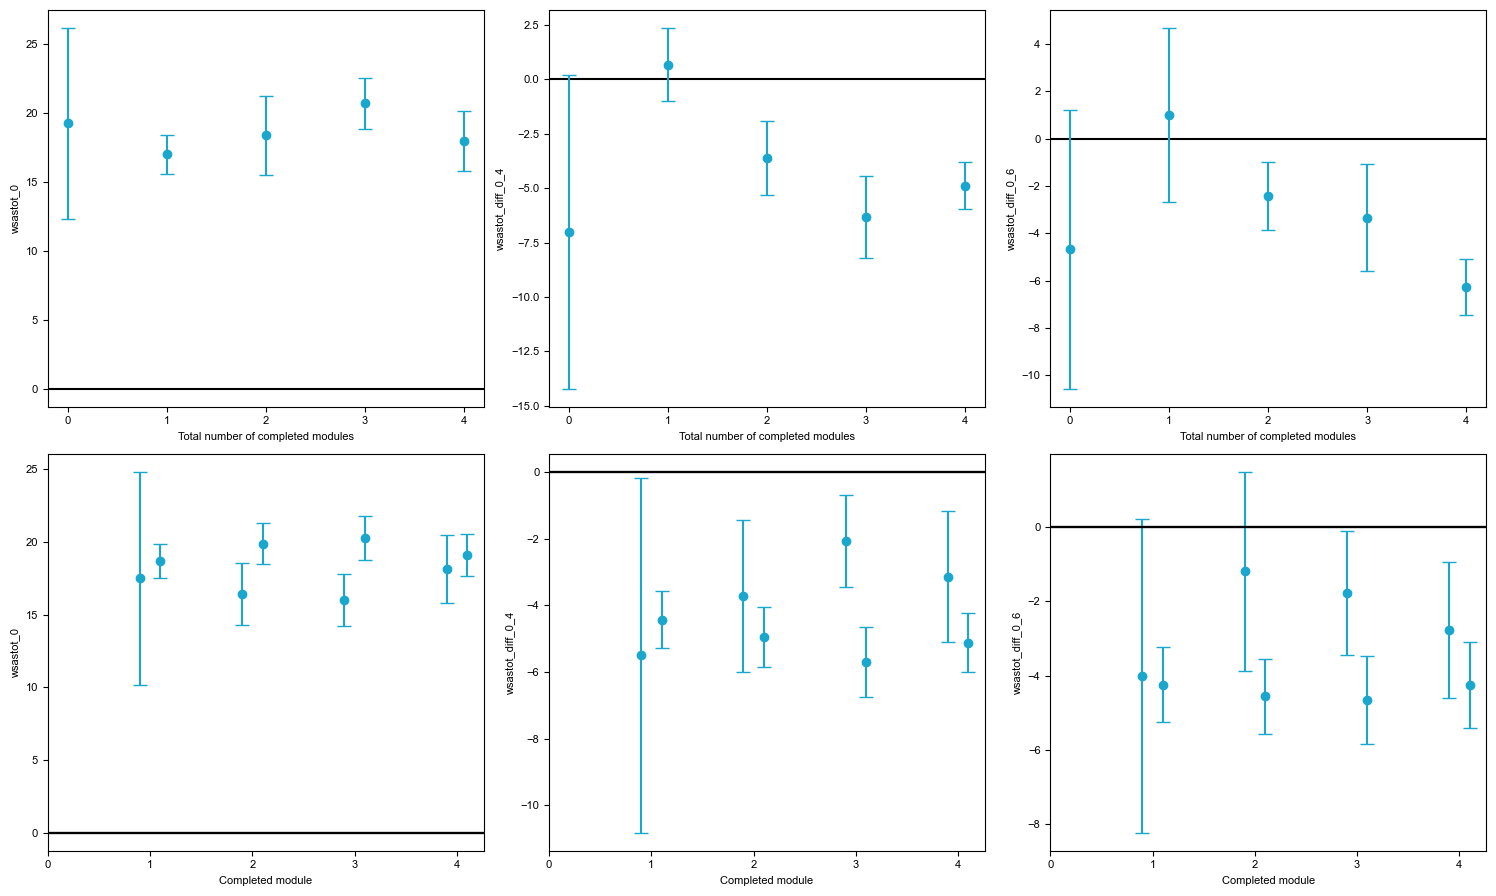




########################
Effect of completing module 1

                            OLS Regression Results                            
Dep. Variable:       wsastot_diff_0_4   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     6.057
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           0.000568
Time:                        11:22:45   Log-Likelihood:                -146.22
No. Observations:                  49   AIC:                             302.4
Df Residuals:                      44   BIC:                             311.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [30]:

vix = 'end_original_w'
satis = df_int[[vix+"1",vix+"2",vix+"3",vix+"4", 'M0M1complete','M2complete', 'M3complete',	'M4complete','wsastot_0', 'wsastot_w4', 'wsastot_w6' ,'age' ]]
satis['wsastot_diff_0_4'] = satis['wsastot_w4'] - satis['wsastot_0']
satis['wsastot_diff_0_6'] = satis['wsastot_w6'] - satis['wsastot_0']
satis['M_sum'] = satis[['M0M1complete','M2complete','M3complete','M4complete']].sum(axis=1)

fig = plt.figure(figsize=(15,9))

for counter, toplot in enumerate(['wsastot_0', 'wsastot_diff_0_4', 'wsastot_diff_0_6']):

    # Calculate mean and standard error of the mean for each group of M_sum values
    grouped = satis.groupby('M_sum')
    means = grouped[toplot].mean()
    sems = grouped[toplot].sem()

    ax = fig.add_subplot(2,3,counter+1)
    ax.axhline(y=0, color = 'k')
    ax.errorbar(means.index, means, yerr=sems, fmt='o', capsize=5, color="#19A7CE", mec="#19A7CE")
    ax.set(xticks = [0,1,2,3,4], xlabel = 'Total number of completed modules', ylabel = toplot)


for counter, toplot in enumerate(['wsastot_0', 'wsastot_diff_0_4', 'wsastot_diff_0_6']):

    ax = fig.add_subplot(2,3,counter+4)
    for i in [1,2,3,4]:
            
        # Calculate mean and standard deviation for each group of M_sum values
        grouped = satis.groupby(vix+str(i))
        means = grouped[toplot].mean()
        sems = grouped[toplot].sem()

        # Plot means with error bars
        ax.axhline(y=0, color = 'k')
        ax.errorbar([i-0.1, i+0.1], means, yerr=sems, fmt='o', capsize=5, color="#19A7CE", mec="#19A7CE")
        ax.set(xticks = [0,1,2,3,4], xlabel = 'Completed module', ylabel = toplot)

plt.tight_layout()

plt.show()



# Completion of module three specifically predicts change in WSAS, but this effect disappears when controlling for WSAS at time 0 and age
for time in ['wsastot_diff_0_4']:

    # which module
    for i in [1,2,3,4]:
        just_dummies = pd.get_dummies(satis[vix+str(i)])
        step1 = pd.concat([satis,just_dummies], axis = 1)
        satis['module_'+(str(i))] = step1['Yes']
      
        result = sm.OLS(satis['wsastot_diff_0_4'], sm.add_constant(satis[['module_'+(str(i)),'wsastot_0','age','M_sum']]), missing='drop').fit()
        print('\n\n\n########################\nEffect of completing module '+ str(i) + '\n')
        print (result.summary())
        
    result = sm.OLS(satis['wsastot_diff_0_4'], sm.add_constant(satis[['module_1','module_2','module_3','module_4','wsastot_0','age','M_sum']]), missing='drop').fit()
    print('\n\n\n########################\nRegression module containing module completion for all models\n')
    print (result.summary())